In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pandas import Series
from matplotlib.patches import Circle
import seaborn as sns
from datetime import datetime,timedelta
import numpy  as np
import scipy.stats as stats
from sklearn.cluster import KMeans
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

zscore_limit = 3
def cleanUpOutliars(df):
    df['Caudal'] = df['Caudal'].clip(upper=40, lower=-20)
    df['zscore'] = stats.zscore(df.Caudal)
    df['mean12'] = df['Caudal'].rolling(24).mean()
    df.loc[df['zscore'] > zscore_limit, 'Caudal'] = df['mean12']


def dataPrep():
    # get data
    dfCaudal = pd.read_excel(r'caudal.xlsx')
    dfCaudal = pd.DataFrame(dfCaudal, columns=['Tempo', 'Caudal'])
    
    # data setup
    dfCaudal['Tempo'] = pd.to_datetime(dfCaudal['Tempo'])
    dfCaudal['Caudal'] = pd.to_numeric(dfCaudal['Caudal'], errors='coerce')
    dfCaudal.set_index('Tempo', inplace=True)
    dfCaudal.dropna(inplace=True)
    
    # split by invalid points - points where time diff is too big > 7
    dfCaudal['timediff'] = dfCaudal.index.to_series().diff()
    dfCaudal.dropna(inplace=True)
    dataSetCuts = dfCaudal[dfCaudal['timediff'] > timedelta(hours=7)]
    
    # zero values were considered
    #dfCaudal =  dfCaudal[dfCaudal['Caudal'] != 0]
    dataSetCuts = pd.concat([dfCaudal.head(1), dataSetCuts, dfCaudal.tail(1)])
    dataSetLists = []
    prev_row = None
    for index, row in  dataSetCuts.iterrows():
         if prev_row is None:
            prev_row = row
         else:
            dataSetLists.append(dfCaudal.loc[prev_row.name:row.name, :].copy())
            prev_row = row
    
    
    # get first and second derivative 
    for index, df in enumerate(dataSetLists):
        cleanUpOutliars(df)
        
         # add previous n(hours) values to collumn 
        n = 20
        for i in range(n):
            df[f'prev_{i+1}'] = df['Caudal'].shift(i+1)
            
        df['diff'] = df['Caudal'].diff()
        df['diff2'] = df['diff'].diff()
        df.dropna(inplace=True)
    return dataSetLists
dataSetList = dataPrep()

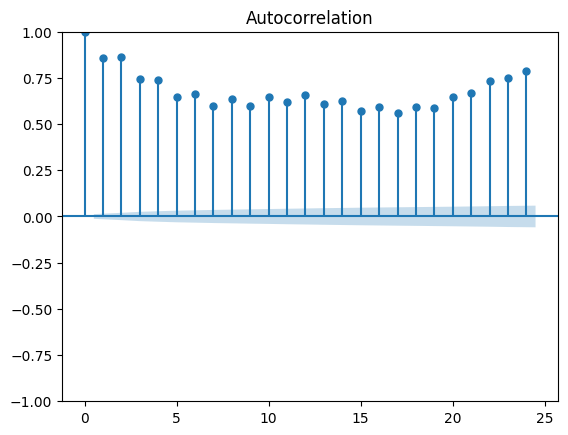

In [40]:
alldata= pd.concat(dataSetList);
series = pd.Series(alldata['Caudal'])
plot_acf(series, lags= 24)

# Show the plot
plt.show()

C:\Users\Francisco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


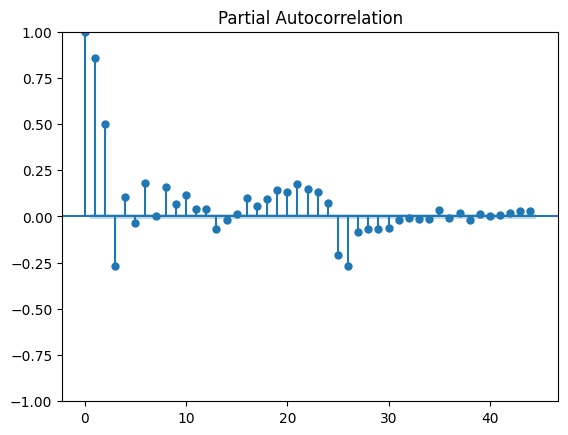

In [41]:
plot_pacf(series, )
plt.show()